# ML Zoomcamp 2023 – Second Capstone Project

[Stanford Dogs Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs)

In [1]:
import os
import re
import subprocess
from pathlib import Path
from time import time
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
try:
    import skimage
    print('Module skimage is installed.')
except ImportError:
    print('Module skimage is not installed, installing it now with pip.')
    p1 = subprocess.run('python -m pip install scikit-image -q', shell=True,
                        check=True, capture_output=True, text=True)
    if p1.stderr:
          print(p1.stderr)
from skimage.io import imread
from skimage.transform import resize

Module skimage is installed.


In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img

In [4]:
images_dir = Path.cwd() / 'data/raw/Images'
annotation_dir = Path.cwd() / 'data/raw/Annotation'
processed_dir = Path.cwd() / 'data/processed'

## Data preparation

In [5]:
# folder names come from namimg in raw/Images and raw/Annotation folders
breed_dir_list = ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound',
                  'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed',
                  'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees',
                  'n02111129-Leonberg']

In [7]:
# modified from https://www.kaggle.com/code/hengzheng/dog-breeds-classifier/notebook
if not processed_dir.exists():
    Path.mkdir(processed_dir, exist_ok=True)
    for breed_dir in breed_dir_list:
        breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
        breed_name = re.sub(r'-', r'_', breed_name.lower())
        Path.mkdir(processed_dir / breed_name, exist_ok=True)
    print(f'''Created {len(os.listdir(processed_dir))} folders to store cropped images of the different breeds.''')
else:
    print(f'Folder {processed_dir} already exists.')

Created 10 folders to store cropped images of the different breeds.


In [9]:
t0 = time()
img_size = 299
print(f'Saving {img_size}x{img_size} image sizes.')
if not list(processed_dir.glob('**/*.jpg')):
    for breed_dir in breed_dir_list:
        counter = 0
        for breed_prefix in os.listdir(f'{annotation_dir}/{breed_dir}'):
            img = Image.open(f'{images_dir}/{breed_dir}/{breed_prefix}.jpg')
            tree = ET.parse(f'{annotation_dir}/{breed_dir}/{breed_prefix}')
            xmin = int(tree.getroot().findall('object')[0].find('bndbox').find('xmin').text)
            xmax = int(tree.getroot().findall('object')[0].find('bndbox').find('xmax').text)
            ymin = int(tree.getroot().findall('object')[0].find('bndbox').find('ymin').text)
            ymax = int(tree.getroot().findall('object')[0].find('bndbox').find('ymax').text)
            img = img.crop((xmin, ymin, xmax, ymax))
            img = img.convert('RGB')
            img = img.resize((img_size, img_size))
            breed_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', breed_dir)
            breed_name = re.sub(r'-', r'_', breed_name.lower())
            img.save(str(processed_dir) + '/' + breed_name + '/' + breed_prefix + '.jpg')
            counter += 1
        print(f'Saved {counter} images in {breed_name} folder.')
    print(f'Time elapsed: {round(time()-t0, 0)} seconds.')
else:
    print(f'Folder {str(processed_dir)} with cropped images already exists.')

Saving 299x299 image sizes.
Saved 252 images in maltese_dog folder.
Saved 239 images in afghan_hound folder.
Saved 232 images in scottish_deerhound folder.
Saved 219 images in pomeranian folder.
Saved 218 images in bernese_mountain_dog folder.
Saved 218 images in samoyed folder.
Saved 218 images in irish_wolfhound folder.
Saved 214 images in shih_tzu folder.
Saved 213 images in great_pyrenees folder.
Saved 210 images in leonberg folder.
Time elapsed: 9.0 seconds.


### Removal of corrupted images

In [10]:
num_skipped = 0
for folder_name in breed_dir_list:
    folder_name = re.sub(r'(n[0-9]+)-(\w+\-?\_?)', r'\2', str(folder_name))
    folder_name = re.sub(r'-', r'_', folder_name.lower())
    breed_dir = processed_dir / folder_name
    print(f'Looking into folder {str(breed_dir)}')
    for fname in os.listdir(breed_dir):
        fpath = breed_dir / fname
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print(f"Deleted {num_skipped} images.")

Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/maltese_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/afghan_hound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/scottish_deerhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/pomeranian
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/bernese_mountain_dog
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/samoyed
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/irish_wolfhound
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/shih_tzu
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/great_pyrenees
Looking into folder /home/jovyan/workspace/ml-zoomcamp/2023/capstone-2/data/processed/leonberg
Deleted

## Pre-trained convolutional neural networks

In [11]:
model = Xception(weights='imagenet', input_shape=(img_size, img_size, 3))

In [12]:
path_to_image = 'data/processed/scottish_deerhound/n02092002_109.jpg'
img = load_img(path_to_image, target_size=(img_size, img_size))
x = np.array(img)
X = np.array([x])
X = preprocess_input(X)
pred = model.predict(X)
decode_predictions(pred)

1/1 [==============================] - 1s 1s/step


[[('n02092002', 'Scottish_deerhound', 0.7939882),
  ('n02090721', 'Irish_wolfhound', 0.04308395),
  ('n02090622', 'borzoi', 0.005164045),
  ('n02091244', 'Ibizan_hound', 0.0030015495),
  ('n02100236', 'German_short-haired_pointer', 0.0029592111)]]

## Data generation

In [13]:
new_img_size = 150
image_size_tuple = (new_img_size, new_img_size)
batch_size = 32

In [14]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    processed_dir,
    validation_split = 0.2,
    subset = 'both',
    seed = 33,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = image_size_tuple,
    batch_size = batch_size,
)

Found 2233 files belonging to 10 classes.
Using 1787 files for training.
Using 446 files for validation.


### Data visualization

In [15]:
names = train_ds.class_names

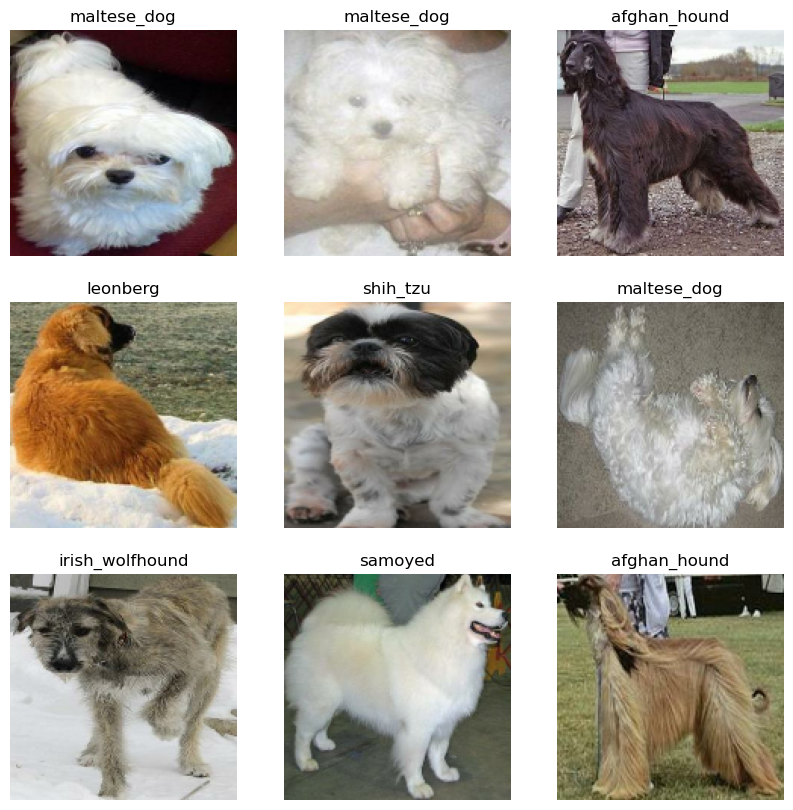

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype('uint8'))
        plt.title(names[list(labels[i]).index(1)])
        plt.axis('off')

## Transfer learning

Using a small image size to decrease training time.

In [17]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
base = base_model(inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [18]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [19]:
history = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
56/56 [==============================] - 49s 824ms/step - loss: 30.2813 - accuracy: 0.2501 - val_loss: 17.1394 - val_accuracy: 0.3161
Epoch 2/10
56/56 [==============================] - 45s 804ms/step - loss: 13.8778 - accuracy: 0.3637 - val_loss: 16.1909 - val_accuracy: 0.3475
Epoch 3/10
56/56 [==============================] - 45s 810ms/step - loss: 10.4882 - accuracy: 0.4264 - val_loss: 17.9481 - val_accuracy: 0.3610
Epoch 4/10
56/56 [==============================] - 45s 809ms/step - loss: 8.9844 - accuracy: 0.4745 - val_loss: 13.8138 - val_accuracy: 0.3700
Epoch 5/10
56/56 [==============================] - 45s 805ms/step - loss: 8.5780 - accuracy: 0.5025 - val_loss: 16.3376 - val_accuracy: 0.3408
Epoch 6/10
56/56 [==============================] - 45s 806ms/step - loss: 9.5243 - accuracy: 0.5204 - val_loss: 18.3655 - val_accuracy: 0.3744
Epoch 7/10
56/56 [==============================] - 45s 804ms/step - loss: 9.7020 - accuracy: 0.5104 - val_loss: 16.7165 - val_accura

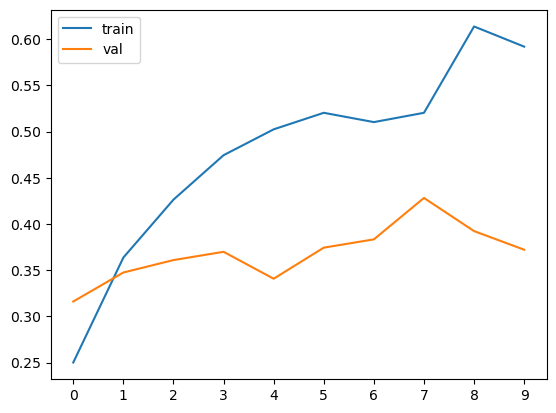

In [20]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

## Data augmentation

In [28]:
data_augmentation_layers = [
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.Rescaling(1./255)
]

In [22]:
def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

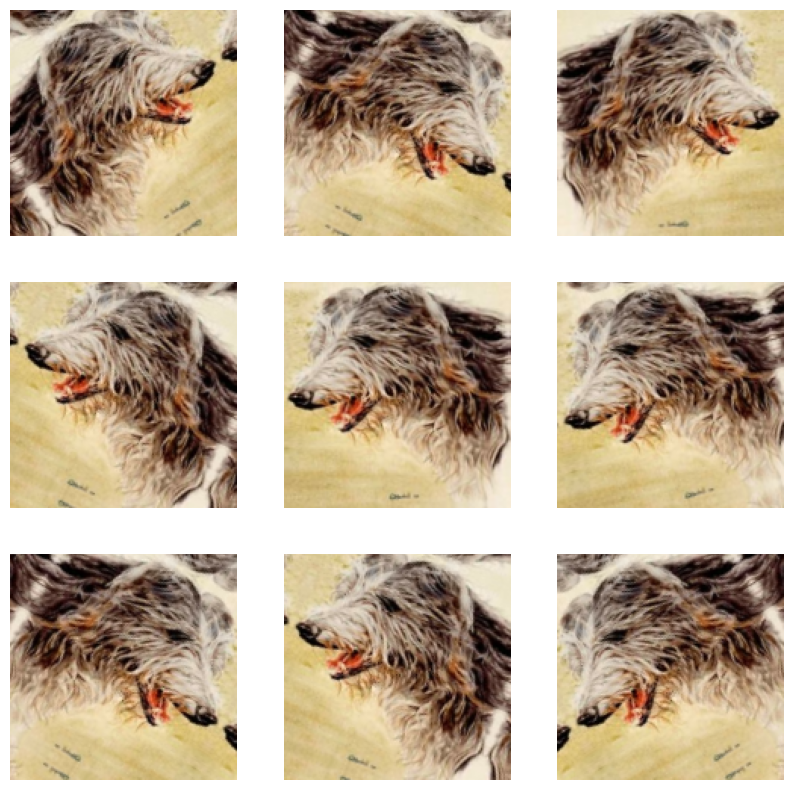

In [26]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype('uint8'))
        plt.axis('off')

In [29]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(new_img_size, new_img_size, 3))
base_model.trainable = False
inputs = keras.Input(shape=(new_img_size, new_img_size, 3))
augmented_inputs = data_augmentation(inputs)
base = base_model(augmented_inputs, training=False)
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(10)(vectors)
model = keras.Model(inputs, outputs)

In [30]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [33]:
history = model.fit(train_ds, epochs = 20, validation_data = val_ds)

Epoch 1/20
56/56 [==============================] - 47s 846ms/step - loss: 0.4054 - accuracy: 0.9200 - val_loss: 0.6338 - val_accuracy: 0.9148
Epoch 2/20
56/56 [==============================] - 47s 840ms/step - loss: 0.4758 - accuracy: 0.9261 - val_loss: 0.5634 - val_accuracy: 0.9081
Epoch 3/20
56/56 [==============================] - 47s 843ms/step - loss: 0.3248 - accuracy: 0.9424 - val_loss: 0.6370 - val_accuracy: 0.9058
Epoch 4/20
56/56 [==============================] - 47s 842ms/step - loss: 0.2928 - accuracy: 0.9457 - val_loss: 0.6051 - val_accuracy: 0.9238
Epoch 5/20
56/56 [==============================] - 47s 848ms/step - loss: 0.3311 - accuracy: 0.9401 - val_loss: 0.7745 - val_accuracy: 0.8991
Epoch 6/20
56/56 [==============================] - 47s 844ms/step - loss: 0.3074 - accuracy: 0.9452 - val_loss: 0.6343 - val_accuracy: 0.9103
Epoch 7/20
56/56 [==============================] - 48s 850ms/step - loss: 0.3842 - accuracy: 0.9334 - val_loss: 0.8929 - val_accuracy: 0.8946

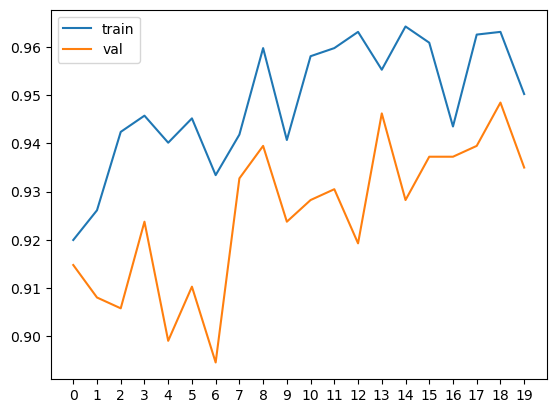

In [34]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(20))
plt.legend()

## Adjusting the learning rate